In [1]:
import warnings
warnings.filterwarnings('ignore')

# About this notebook

Author: Anubhav Jain

Github repo: https://github.com/computron/matcalc_tutorial/

Video tutorial: https://youtu.be/57Elhe4IIhI

![Matcalc tutorial](graphics/title.png "Matcalc Tutorial")

# Tutorial overview

In this tutorial, we are going to learn to very quickly simulate materials properties such as surface energies, thermal properties, and mechanical properties using the *matcalc* software. Advancements in machine learning interatomic potentials have made such simulations extremely fast and simple.


More information about the theory of machine learned potentials can be found in a previous video: https://youtu.be/tWeBrPTrSDE

In this tutorial, we'll focus on hands-on practical running of simulations. We will complete the following tasks:

1. Optimize structural parameters and calculate the total energy of GaAs
    - Repeat the calculation with a different interatomic potential / potential energy surface from matgl
    - Repeat the calculation with a different potential from the internet
2. Calculate surface energy of Si(111)
3. Calculate the phonon dispersion of Si
4. Calculate the elastic tensors of 25 different materials with parallelization

Let's get started!

# Installation of packages

The first step is to install all required packages via ``pip``. We need:

* the core ``matcalc`` library

Additionally, it is highly recommended (and necessary for this tutorial) to install:
* the ``matgl`` library, which provides some universal potential for us to use
* the ``seekpath`` library, which is needed to calculate phonon band structures

Finally, it is optional to install:
* the ``crystal_toolkit`` library, which helps with visualization in the notebook

In [2]:
# !pip install matcalc

# !pip install matgl
# !pip install seekpath

# !pip install crystal-toolkit

# Task 1. Optimize structural parameters and calculate the total energy of GaAs

One of the most common tasks in materials modeling is optimizing the structural parameters of a crystal structure and calculating its total energy following the relaxation.

As the target structure, we will load the experimental structure of GaAs from the Crystallography Open Database, or COD, from a CIF file.

If you use structures from the COD for your own work, please make sure to cite their resource: https://wiki.crystallography.net/cod/citing/


Let's start by loading and visualizing the GaAs structure. We will use the *pymatgen* code to create a ``Structure`` object.

For more details about *pymatgen* ``Structure`` objects, as well as additional ways to load crystal structures, see Part 1 of the pymatgen tutorial: https://youtu.be/b0tieiedGdg

In [3]:
import crystal_toolkit  # for interactive visualization only; can omit if causing problems
import os
from pymatgen.core import Structure

# Get a structure we want to optimize
gaas_expt = Structure.from_file(os.path.join("structures", "GaAs.cif"))  # expt. structure from COD
print(gaas_expt)
gaas_expt

Full Formula (Ga4 As4)
Reduced Formula: GaAs
abc   :   5.653700   5.653700   5.653700
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Ga    0     0     0
  1  Ga    0     0.5   0.5
  2  Ga    0.5   0     0.5
  3  Ga    0.5   0.5   0
  4  As    0.25  0.25  0.25
  5  As    0.25  0.75  0.75
  6  As    0.75  0.25  0.75
  7  As    0.75  0.75  0.25


Let's now perturb the structure from its initial position. We will do this by expanding the lattice parameters as well as adding random noise to the atom positions.

In [4]:
gaas_perturbed = gaas_expt.copy().perturb(0.2)  # perturb atom positions
gaas_perturbed.scale_lattice(gaas_expt.volume * 1.2)  # expand the lattice

print(gaas_perturbed)
gaas_perturbed

Full Formula (Ga4 As4)
Reduced Formula: GaAs
abc   :   6.007953   6.007953   6.007953
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Ga    0.009005  0.011749  0.992344
  1  Ga    0.009718  0.519051  0.509379
  2  Ga    0.511374  0.997019  0.50229
  3  Ga    0.503599  0.496592  0.995347
  4  As    0.248679  0.249762  0.250481
  5  As    0.281917  0.750602  0.753249
  6  As    0.7523    0.248792  0.754207
  7  As    0.767896  0.77708   0.2407


Ok, now it's time to optimize our perturbed structure using universal potentials. The first thing we need to do is to select a potential energy surface. The *matcalc* code refers to these as "calculators".

We can print out a list of all calculators bundled with the *matgl* code that we previously installed (later we'll show how to use other potentials not bundled with *matgl*).

In [5]:
import matcalc
from matcalc.utils import UNIVERSAL_CALCULATORS

import pprint
pprint.pprint(list(UNIVERSAL_CALCULATORS))  # calculators that come with bundled with matgl

[<UNIVERSAL_CALCULATORS.CHGNet: 'CHGNet'>,
 <UNIVERSAL_CALCULATORS.CHGNet-MPtrj-2023.12.1-2.7M-PES: 'CHGNet-MPtrj-2023.12.1-2.7M-PES'>,
 <UNIVERSAL_CALCULATORS.CHGNet-MPtrj-2024.2.13-11M-PES: 'CHGNet-MPtrj-2024.2.13-11M-PES'>,
 <UNIVERSAL_CALCULATORS.CHGNet-MatPES-PBE-2025.2.10-2.7M-PES: 'CHGNet-MatPES-PBE-2025.2.10-2.7M-PES'>,
 <UNIVERSAL_CALCULATORS.CHGNet-MatPES-r2SCAN-2025.2.10-2.7M-PES: 'CHGNet-MatPES-r2SCAN-2025.2.10-2.7M-PES'>,
 <UNIVERSAL_CALCULATORS.DeePMD: 'DeePMD'>,
 <UNIVERSAL_CALCULATORS.FAIRChem: 'FAIRChem'>,
 <UNIVERSAL_CALCULATORS.GRACE: 'GRACE'>,
 <UNIVERSAL_CALCULATORS.M3GNet: 'M3GNet'>,
 <UNIVERSAL_CALCULATORS.M3GNet-ANI-1x-Subset-PES: 'M3GNet-ANI-1x-Subset-PES'>,
 <UNIVERSAL_CALCULATORS.M3GNet-MP-2021.2.8-DIRECT-PES: 'M3GNet-MP-2021.2.8-DIRECT-PES'>,
 <UNIVERSAL_CALCULATORS.M3GNet-MP-2021.2.8-PES: 'M3GNet-MP-2021.2.8-PES'>,
 <UNIVERSAL_CALCULATORS.M3GNet-MatPES-PBE-v2025.1-PES: 'M3GNet-MatPES-PBE-v2025.1-PES'>,
 <UNIVERSAL_CALCULATORS.M3GNet-MatPES-r2SCAN-v2025.1-PE

For ease of use, we can use shortcuts to get "recommended" potentials for various levels of theory used in the training data. Note that these recommended potentials might change with time, so if you need stability you should specify the potential name explicitly.

For now, we'll load the default model that is trained on DFT-PBE level data.

In [6]:
from matcalc.utils import MODEL_ALIASES
pprint.pprint(MODEL_ALIASES)  # list all "aliased" models

{'chgnet': 'CHGNet-MatPES-PBE-2025.2.10-2.7M-PES',
 'm3gnet': 'M3GNet-MatPES-PBE-v2025.1-PES',
 'pbe': 'TensorNet-MatPES-PBE-v2025.1-PES',
 'r2scan': 'TensorNet-MatPES-r2SCAN-v2025.1-PES',
 'tensornet': 'TensorNet-MatPES-PBE-v2025.1-PES'}


In [7]:
calculator_pbe = matcalc.load_fp("pbe")  # recommended calculator for PBE functional - note default can change over time!
# calculator_pbe = matcalc.load_fp("TensorNet-MatPES-PBE-v2025.1-PES")  # enforce calculator explicitly

FileNotFoundError: Cannot find DGL C++ graphbolt library at /home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/dgl/graphbolt/libgraphbolt_pytorch_2.4.0.so

Now that we have a calculator object, we can run a simulation with *matcalc*. We need to specify the type of simulation we want to do by instantiating the appropriate Property Calclulator from *matcalc*, and then call the ``calc()`` function on our desired structure.

Here, we will try to optimize our perturbed structure to see if we can recover our original cell volume and crystallographic atom positions using the structure optimization.

In [ ]:
import dgl
dgl.__version__

'2.4.0+cu124'

In [ ]:
relax_calc = matcalc.RelaxCalc(
    calculator_pbe,
    optimizer="FIRE",
    relax_atoms=True,
    relax_cell=True,
)

data = relax_calc.calc(gaas_perturbed)

Now that we have the data from the relaxation simulation, we can examine it. It contains not only the optimized structure, but also the energy of the configuration, forces on atoms, and cell stress after optimization.

In [ ]:
pprint.pprint(data)

{'a': 5.7734804409904505,
 'alpha': 90.01124780224458,
 'b': 5.768994381858776,
 'beta': 89.99413549518073,
 'c': 5.768379733074091,
 'energy': -33.08741760253906,
 'final_structure': Structure Summary
Lattice
    abc : 5.7734804409904505 5.768994381858776 5.768379733074091
 angles : 90.01124780224458 89.99413549518073 89.99072677793988
 volume : 192.12843309306697
      A : 5.773480414723976 0.0004656891586328208 0.00029399245471914713
      B : 0.0004684032168309412 5.768994335039446 -0.0005663914927839006
      C : 0.0002967349774808317 -0.0005660903943359264 5.768379697664669
    pbc : True True True
PeriodicSite: Ga (0.05957, 0.04122, 5.766) [0.01027, 0.007242, 0.9996]
PeriodicSite: Ga (0.0512, 2.929, 2.883) [0.008801, 0.5078, 0.4999]
PeriodicSite: Ga (2.951, 0.02462, 2.882) [0.5112, 0.004275, 0.4995]
PeriodicSite: Ga (2.933, 2.911, 5.771) [0.5079, 0.5046, 1.0]
PeriodicSite: As (1.499, 1.478, 1.445) [0.2596, 0.2561, 0.2504]
PeriodicSite: As (1.501, 4.359, 4.326) [0.2599, 0.7556, 0

In [ ]:
final_structure_pbe = data["final_structure"]
print(final_structure_pbe)
final_structure_pbe

Full Formula (Ga4 As4)
Reduced Formula: GaAs
abc   :   5.773480   5.768994   5.768380
angles:  90.011248  89.994135  89.990727
pbc   :       True       True       True
Sites (8)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Ga    0.010267  0.007242  0.999594
  1  Ga    0.008801  0.507765  0.499928
  2  Ga    0.511184  0.004275  0.499527
  3  Ga    0.507895  0.504645  1.0004
  4  As    0.259644  0.256124  0.250448
  5  As    0.259853  0.755598  0.749927
  6  As    0.759183  0.256884  0.750972
  7  As    0.760176  0.755455  0.248926


Examining the structure, we will see that we got close to recovering our perfect crystallographic atom positions. 

Our cell volume is also closer to experiment than the perturbed structure; however, because the DFT-PBE training data tends to overestimate lattice parameters, the corresponding machine-learned potential also produces cell lengths slightly larger than experiment.

## Task 1b. Repeat the calculation with a different interatomic potential / potential energy surface from matgl

Now let's repeat the same structure optimization, but use a different machine-learned interatomic potential from the *matgl* library. In particular, we will use a potential trained on meta-GGA calculations (the r2SCAN method) that is typically more accurate than PBE. However, less training data is available for r2SCAN calculations.

In [ ]:
calculator_r2scan = matcalc.load_fp("r2scan")  # recommended calculator for r2scan functional

In [ ]:
relax_calc = matcalc.RelaxCalc(
    calculator_r2scan,
    optimizer="FIRE",
    relax_atoms=True,
    relax_cell=True,
)

data = relax_calc.calc(gaas_perturbed)
final_structure_r2scan = data["final_structure"]
print(final_structure_r2scan)
final_structure_r2scan

Full Formula (Ga4 As4)
Reduced Formula: GaAs
abc   :   5.645782   5.641368   5.639459
angles:  89.986830  89.977647  89.974592
pbc   :       True       True       True
Sites (8)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Ga    0.009756  0.005605  0.999683
  1  Ga    0.009371  0.504746  0.499444
  2  Ga    0.50961   0.006444  0.500398
  3  Ga    0.509602  0.507127  1.00024
  4  As    0.259675  0.255571  0.250292
  5  As    0.259715  0.756231  0.749871
  6  As    0.759631  0.255946  0.749914
  7  As    0.759644  0.756319  0.249889


We see that this potential has better reproduced the lattice parameters of GaAs starting from the perturbed structure.

## Task 1c. Repeat the calculation with a different potential from the internet

Now, let's use a potential that is not bundled with *matgl*. The *matcalc* software can use any potential that implements an ``ASECalculator``.

For example, the MACE library distributes foundation models that implement the ASE calculator:
https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html

We can thus install the *mace-torch* library and load the corresponding calculator for use with *matcalc*.

In [ ]:
!pip install mace-torch

In [ ]:
from mace.calculators import mace_mp

calculator_macemp = mace_mp()  #  load the MACE calculator

print("-"*46)
print("Class hierarchy for the MACE calculator object")
print("-"*46)
print(type(calculator_macemp).__mro__)  # demonstrate that this implements the ASE Calculator model

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Cached MACE model to /home/lengze/.cache/mace/macempa0mediummodel
Using Materials Project MACE for MACECalculator with /home/lengze/.cache/mace/macempa0mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head default out of ['default']
Default dtype float32 does not match model dtype float64, converting models to float32.
----------------------------------------------
Class hierarchy for the MACE calculator object
----------------------------------------------
(<class 'mace.calculators.mace.MACECalculator'>, <class 'ase.calculators.calculator.Calculator'>, <class 'ase.calculators.calculator.BaseCalculator'>, <class 'ase.calculators.abc.GetPropertiesMixin'>, 

It is now straightforward to run the structure optimization with MACE.

Note that this potential is also trained on PBE data, so overestimation of lattice parameters is expected.

In [ ]:
relax_calc = matcalc.RelaxCalc(
    calculator_macemp,
    optimizer="FIRE",
    relax_atoms=True,
    relax_cell=True,
)

data = relax_calc.calc(gaas_perturbed)

final_structure_mace = data["final_structure"]
print(final_structure_mace)
final_structure_mace

Full Formula (Ga4 As4)
Reduced Formula: GaAs
abc   :   5.725369   5.723081   5.718603
angles:  90.007362  89.995081  90.003503
pbc   :       True       True       True
Sites (8)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Ga    0.009881  0.006838  0.999514
  1  Ga    0.009404  0.505805  0.500307
  2  Ga    0.510443  0.006286  0.5005
  3  Ga    0.509576  0.505596  1.00005
  4  As    0.259097  0.255087  0.251024
  5  As    0.259882  0.756652  0.750233
  6  As    0.759571  0.255407  0.748992
  7  As    0.759149  0.756316  0.249107


# Task 2. Calculate surface energy of Si

Let's now switch to a different type of simulation. Next, we will calculate the surface energy of the (111) surface of silicon. This will involve cleaving the (111) surface and comparing the per-atom energy of the surface slab to the bulk cell.

Let's start by loading the conventional structure of Si retrieved from the Crystallography Open Database.

In [ ]:
si_expt = Structure.from_file(os.path.join("structures", "Si.cif"))  # expt structure from COD
print(si_expt)
si_expt

Full Formula (Si8)
Reduced Formula: Si
abc   :   5.430700   5.430700   5.430700
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0     0.5   0.5
  2  Si    0.5   0     0.5
  3  Si    0.5   0.5   0
  4  Si    0.75  0.75  0.25
  5  Si    0.75  0.25  0.75
  6  Si    0.25  0.75  0.75
  7  Si    0.25  0.25  0.25


Next, we will create the slab cell that contains the Si(111) surface.

Note that multiple slabs can be created depending on the details of the surface cleaving, which may result in different surface energies. The ``calc_slabs()`` function has various options that can be used to control the slab properties, but for now we will just use defaults.

In [ ]:
surface_calc = matcalc.SurfaceCalc(calculator_pbe)
slab_data = surface_calc.calc_slabs(si_expt, miller_index=(1, 1, 1), inplane_supercell=(2,2))

slab_structure = slab_data[0]["slab"]
print(slab_structure)
slab_structure

Slab Summary (Si32)
Reduced Formula: Si
Miller index: (1, 1, 1)
Shift: 0.3750, Scale Factor: [[-1  1  0]
 [-1  0  1]
 [ 1  0  0]]
abc   :   7.680170   7.680170  34.560763
angles:  86.815261  86.815261  60.000000
Sites (32)
1 Si     0.301136     0.301136     0.943182
2 Si     0.301136     0.801136     0.943182
3 Si     0.801136     0.301136     0.943182
4 Si     0.801136     0.801136     0.943182
5 Si     0.130682     0.130682     0.965909
6 Si     0.130682     0.630682     0.965909
7 Si     0.630682     0.130682     0.965909
8 Si     0.630682     0.630682     0.965909
9 Si     0.482955     0.482955     0.852273
10 Si     0.482955     0.982955     0.852273
11 Si     0.982955     0.482955     0.852273
12 Si     0.982955     0.982955     0.852273
13 Si     0.312500     0.312500     0.875000
14 Si     0.312500     0.812500     0.875000
15 Si     0.812500     0.312500     0.875000
16 Si     0.812500     0.812500     0.875000
17 Si     0.164773     0.164773     0.761364
18 Si     0.164773   

With our slab structure determined, we can calculate a surface energy by comparing the slab energy to the bulk.

Surface energies are difficult to measure, but for Si(111), we are aiming to get an unreconstructed surface energy of \~0.1 eV/A^2 which is \~1.6 J/m^2.

(1) Tran, R.; Xu, Z.; Radhakrishnan, B.; Winston, D.; Sun, W.; Persson, K. A.; Ong, S. P. Surface Energies of Elemental Crystals. Sci Data 2016, 3 (1), 160080. https://doi.org/10.1038/sdata.2016.80.

See also: http://crystalium.materialsvirtuallab.org

In [ ]:
surface_data = surface_calc.calc({"bulk": si_expt, "slab": slab_structure})
print(surface_data["surface_energy"])

0.06070073666217083


The basic calculation underestimates, so caution is needed when doing these kinds of simulations quickly.

However, we will keep moving forward.

# Task 3: Calculate the phonon dispersion of Si

Next, we'll calculate the phonon dispersion of Si. The phonon dispersion provides information about crystalline vibrations which can be related to thermal conductivity, heat capacity, free energy, and other materials properties.

More information about how to interpret phonon dispersions can be found here: https://youtu.be/acT6zQbiiio

Calculating phonon properties is as easy as running the ``PhononCalc`` Property Calculator on the target structure.

We will load the primitive cell (with the fewest number of atoms in the unit cell) to make the calculations efficient as well as to have a more interpretable band structure.

In [ ]:
si_primitive = Structure.from_file(os.path.join("structures", "Si_primitive_mp-149.cif"))
si_primitive

After loading the structure, running the phonon calculation is as easy as invoking the ``PhononCalc`` property calculator using our potential energy function of choice.

In [ ]:
from matcalc import PhononCalc
phonon_calc = PhononCalc(calculator_pbe, relax_structure=True, 
                         write_band_structure=os.path.join("outputs", "si_phonon_bs.yaml"),
                         write_total_dos=os.path.join("outputs", "si_phonon_dos.dat"),
                         write_phonon=os.path.join("outputs", "si_phonon.yaml"))
data = phonon_calc.calc(si_primitive)

/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/seekpath/hpkot/__init__.py:172: DeprecationWarning:

dict interface is deprecated. Use attribute interface instead



Let's now plot the phonon dispersion.

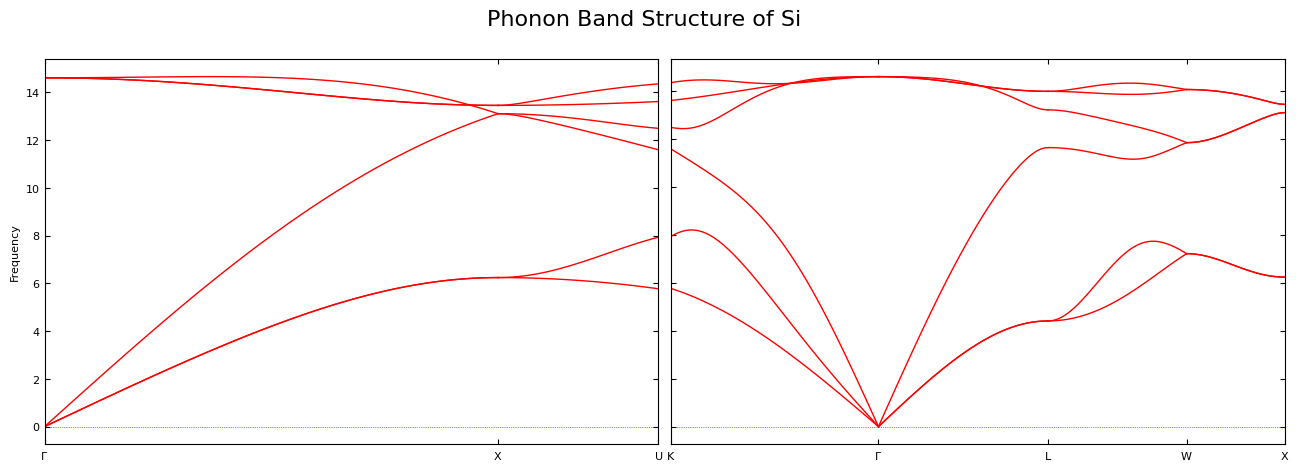

In [ ]:
import matplotlib.pyplot as plt

phonon_bs = data["phonon"].band_structure  # get the phonon band structure

# Plotting code below here -->
n_axes = sum(1 for c in phonon_bs.path_connections if not c)
# Create n_axes subplot(s) along 1 row
fig, axs = plt.subplots(1, n_axes, figsize=(16, 5))
# If only one axis is created, wrap it into a list
if n_axes == 1:
    axs = [axs]

    # Remove y-axis labels & ticks from all but the first subplot
for ax in axs[1:]:
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelleft=False)

phonon_bs.plot(ax=axs)
fig.suptitle("Phonon Band Structure of Si", fontsize=16)
plt.subplots_adjust(wspace=0.02)  # Remove horizontal space so they almost touch
plt.show()



We can also plot the phonon density of states, or DOS.

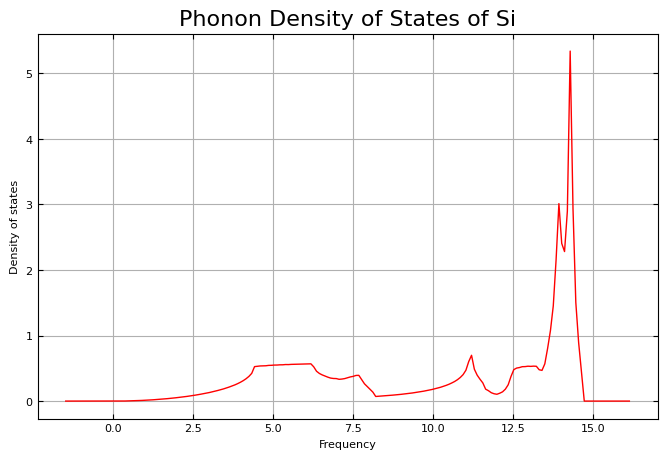

In [ ]:
phonon_dos = data["phonon"].total_dos

fig, ax = plt.subplots(figsize=(8, 5))
phonon_dos.plot(ax=ax)
plt.title("Phonon Density of States of Si", fontsize=16)
plt.show()

Finally, let's plot the vibrational heat capacity of the material.

Note that the heat capacity is plotted in J/mol*K, where we are referring to **mols of the formula unit / molecule in the unit cell**. Since our unit cell contained 2 atoms of Si, this is the heat capacity per 2 mols of Si, not per mol of Si.

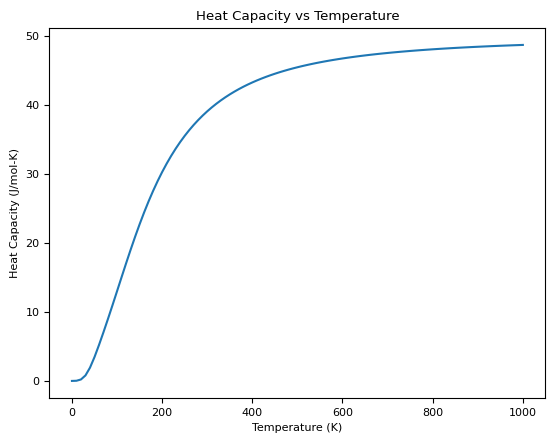

In [ ]:
# plot the heat capacity
import matplotlib.pyplot as plt
plt.plot(data["thermal_properties"]["temperatures"], data["thermal_properties"]["heat_capacity"])
plt.xlabel("Temperature (K)")
plt.ylabel("Heat Capacity (J/mol-K)")
plt.title("Heat Capacity vs Temperature")
plt.show()

All this thermal data can be compared, for example, to phonon data in the Materials Project: https://next-gen.materialsproject.org/materials/mp-149?material_ids=mp-149

# Task 4. Calculate 25 elastic tensors with parallelization

The *matcalc* software includes basic facilities to parallelize individual calculations over various processing cores. This is as simple as replacing the ``calc()`` function in a Property Calculator with the ``calc_many()`` function, and providing a list of ``Structure`` objects instead of a single object.

Let's use this functionality to calculate the elastic tensors of 25 materials in parallel.

Let's first load 25 structures.

In [ ]:
import glob

# Find all .cif files in the "cifs_mp" folder
cif_files = glob.glob("structures_batch/*.cif")  # folder contains assorted crystal structures from Materials Project
structures = []
for cif_file in cif_files:
    structures.append(Structure.from_file(cif_file))
    
print(len(structures))

25


We can now use the ``calc_many()`` function of ``ElasticityCalc`` to calculate elastic moduli of all these materials. Note that casting the result to a list forces the calculatons to take place and ``njobs=-1`` tries to use all cores on your processor.

We'll time how long it takes to calculate 25 elastic tensors using the ``%%time`` magic command.

In [ ]:
%%time

from matcalc import ElasticityCalc
elastic_calc = ElasticityCalc(calculator_pbe, relax_structure=True)
elastic_data = list(elastic_calc.calc_many(structures, n_jobs=-1))

/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/home/le

CPU times: user 500 ms, sys: 246 ms, total: 746 ms
Wall time: 12 s


Our 25 calculations are complete - let's now print out our results! Note that each item contains more data, we will just print out various elastic moduli instead of the full elastic tensor.

In [ ]:
multiplier_GPa = 160.2176621  # unit conversions for eV/A^3 to GPa

for idx, data_item in enumerate(elastic_data):
    print(cif_files[idx])
    print("--------")
    print(f"Bulk modulus: {data_item['bulk_modulus_vrh'] * multiplier_GPa} GPa")
    print(f"Shear modulus: {data_item['shear_modulus_vrh'] * multiplier_GPa} GPa")
    print("\n")

structures_batch/SiC_mp-8062.cif
--------
Bulk modulus: 222.54536784047772 GPa
Shear modulus: 192.83975129603317 GPa


structures_batch/HgS_mp-634.cif
--------
Bulk modulus: 65.3056682911571 GPa
Shear modulus: 17.854953434885537 GPa


structures_batch/SmNi5_mp-1075.cif
--------
Bulk modulus: 121.9336603884339 GPa
Shear modulus: 59.73941205507692 GPa


structures_batch/BaTiO3_mp-5986.cif
--------
Bulk modulus: 141.78232988315486 GPa
Shear modulus: 85.02936979003316 GPa


structures_batch/C_mp-48.cif
--------
Bulk modulus: 89.01811427332967 GPa
Shear modulus: 87.61886375988998 GPa


structures_batch/Al2O3_mp-1143.cif
--------
Bulk modulus: 198.09193316275181 GPa
Shear modulus: 150.19819631245426 GPa


structures_batch/Ce_mp-64.cif
--------
Bulk modulus: 36.162462423670775 GPa
Shear modulus: 16.79903812680155 GPa


structures_batch/InP_mp-20351.cif
--------
Bulk modulus: 61.179679396600456 GPa
Shear modulus: 39.036514477720736 GPa


structures_batch/TiO2_mp-2657.cif
--------
Bulk modulus:

These values can be compared against calculation in the Materials Project, for example: https://next-gen.materialsproject.org/materials/mp-149

You can also get the full 3x3x3x3 (``C_ijkl``) elastic tensor (in eV/A^3) for any material.

In [ ]:
print(cif_files[0])
print(f"Elastic tensor: {elastic_data[0]['elastic_tensor']}")

structures_batch/SiC_mp-8062.cif
Elastic tensor: [[[[ 3.25085008e+00 -3.84524788e-01 -3.25204610e-06]
   [-3.84524788e-01  3.22293062e-01 -1.17545028e-06]
   [-3.25204610e-06 -1.17545028e-06  5.93510419e-01]]

  [[-3.89836350e-01  1.05595122e+00  2.81250792e-07]
   [ 1.05595122e+00 -3.13319825e-02  3.18441167e-07]
   [ 2.81250792e-07  3.18441167e-07  3.95649026e-01]]

  [[-1.30385160e-07  3.24410697e-07  1.35203633e+00]
   [ 3.24410697e-07  4.61004674e-07  4.13841919e-01]
   [ 1.35203633e+00  4.13841919e-01  1.06481214e-06]]]


 [[[-3.89836350e-01  1.05595122e+00  2.81250792e-07]
   [ 1.05595122e+00 -3.13319825e-02  3.18441167e-07]
   [ 2.81250792e-07  3.18441167e-07  3.95649026e-01]]

  [[ 3.22249923e-01 -1.93682013e-07  2.22273741e-06]
   [-1.93682013e-07  3.52363707e+00  2.45075967e-06]
   [ 2.22273741e-06  2.45075967e-06  3.22249401e-01]]

  [[ 1.00582838e-06 -4.93212913e-07  4.08569174e-01]
   [-4.93212913e-07 -1.04773790e-06  1.06129486e+00]
   [ 4.08569174e-01  1.06129486e+00  5

# Other functionalities

The *matcalc* code contains other functionalities, including:

* additional property calculators, like nudged elastic band (NEB) activation energies, third order phonons, and molecular dynamics runs
* basic workflow capabilities, such as defining a chain of calculators that can be re-used.

To learn these functionalities, please check the official documentation at:
* https://github.com/materialsvirtuallab/matcalc
* https://matcalc.ai

![NEB calc](graphics/neb.png "NEB calculation")
